<a href="https://colab.research.google.com/github/asu-trans-ai-lab/QVDF/blob/main/PAQ_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PAQ

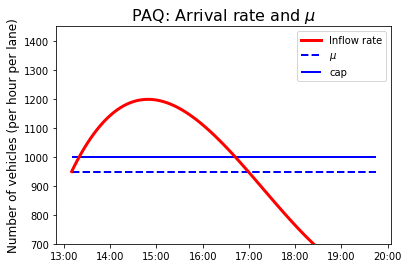

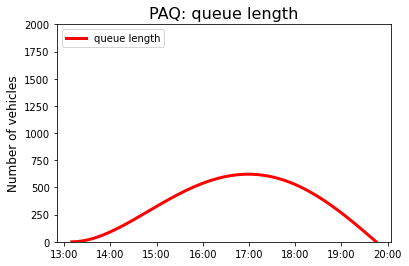

In [1]:
import numpy as np
from math import sqrt
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.rc('font',family='Times New Roman')


class PAQ():
    
    def __init__(self, t0, t3, v_f, mu, v_mu, start_time_index, end_time_index):
        self.t0 = t0
        self.t3 = t3
        self.v_f = v_f
        self.mu = mu
        self.v_mu = v_mu
        self.P = t3 - t0
        self.start_time_index = start_time_index
        self.end_time_index = end_time_index
        self.t = np.linspace(t0, t3, num=100)
        
    def get_virtual_queue(self, gamma, m):
        virtual_queue = np.zeros(len(self.t))
        for i in range(len(self.t)):
            virtual_queue[i] = gamma*(self.t[i] - self.t0)**2*(0.25*(self.t[i] - self.t0)**2 - 1/3*((3-4*m)/(4-6*m)+m)*(self.t3 - self.t0)*(self.t[i] - self.t0) + 1/2*(3 - 4*m)*m/(4 - 6*m)*((self.t3 - self.t0)**2))
        return virtual_queue
    
    def cubic_model_Q(self, x, obsQueue):
        # parameters
        gamma = x[0]
        m = x[1]
        # initialization
        Q_t = np.zeros(len(self.obsQueue))
        # theoretical values
        for i in range(len(self.obsCumulativeDeparture)):
            Q_t[i] = 1/self.factor_virQueue2phyQueue*gamma*(self.t[i] - self.t0)**2*(0.25*(self.t[i] - self.t0)**2 - 1/3*((3-4*m)/(4-6*m)+m)*(self.t3 - self.t0)*(self.t[i] - self.t0) + 1/2*(3 - 4*m)*m/(4 - 6*m)*((self.t3 - self.t0)**2))
        obj_fun = np.sum((Q_t - obsQueue)**2)
        return obj_fun
    
    def constraint1(self, x):
        gamma = x[0]
        m = x[1]
        t2 = self.t0 + m*(self.t3 - self.t0)
        t_bar = self.t0 + (3 - 4*m)*(self.t3 - self.t0)/(4 - 6*m)
        inflow_rate = gamma*(self.t - self.t0)*(self.t - t2)*(self.t - t_bar) + self.mu
        return inflow_rate
    
    def bounds(self):
        bounds = np.asarray([[1, 20], [0.5, 0.666]])  # lower and upper bounds for gamma and m
        return bounds
    
    def initial_value(self):
        x0 = np.asarray([10.0, 0.58])
        return x0
    
    def calibration_with_newton(self):
        x0 = self.initial_value()
        solution = minimize(self.cubic_model_Q, x0, method='Newton-CG', jac = self.Z_first_order_derivative, hess = self.Z_second_order_derivative, 
                            options={'maxiter': 1000, 'xtol': 1e-12, 'eps': 1e-12, 'disp': False})
        gamma, m = solution.x
        obj = solution.fun
        return gamma, m, obj
    
      
    def plot_InflowRate(self, mu, gamma, m, lane_capacity):
        # Plot inflow rate
        fig = plt.figure()
        inflow_rate = gamma*(self.t - self.t0)*(self.t - self.t0 - m*(self.t3 - self.t0))*(self.t - self.t0 - (3-4*m)*(self.t3 - self.t0)/(4 - 6*m)) + mu
        plt.plot(self.t, inflow_rate, 'r-', linewidth=3, label = 'Inflow rate')
        plt.hlines(mu, self.t0, self.t3, colors = 'b', linestyles = 'dashed', linewidth=2, label = '$\mu$')
        plt.hlines(lane_capacity, self.t0, self.t3, colors = 'b', linewidth=2, label = 'cap')
        plt.xticks([13+i for i in range(0,8)], 
                    labels=['13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00'], fontsize=10)
        plt.ylabel('Number of vehicles (per hour per lane)', fontsize=12)
        plt.ylim((700, 1450))
        plt.legend(loc=0)
        plt.title('PAQ: Arrival rate and $\mu$', fontsize=16)
#        fig.savefig('../Figures/Case 1/Inflow rate.png', dpi=300, bbox_inches='tight')
    
    def plot_QueueLength(self, mu, gamma, m):
        # Plot queue length
        fig = plt.figure()
        calQueue = self.get_virtual_queue(gamma,m)
#        plt.scatter(self.t, calQueue, s = 2, marker='Q', c='b', edgecolors='b', label='queue')
        plt.plot(self.t, calQueue, 'r-', linewidth=3, label = 'queue length')
        plt.xticks([13+i for i in range(0,8)], 
                    labels=['13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00'], fontsize=10)
        plt.ylabel('Number of vehicles', fontsize=12)
        plt.ylim((0, 2000))
        plt.legend(loc=2)
        plt.title('PAQ: queue length', fontsize=16)
#        fig.savefig('../Figures/Case 1/Calibration of queue.png', dpi=300, bbox_inches='tight')
        

class QVDF():
    def __init__(self, V, L, plf, C, t2, Q_cd, Q_n):
        self.V = V
        self.L = L
        self.plf = plf
        self.D = 0
        self.C = C
        self.t2 = t2
        self.Q_cd = Q_cd
        self.Q_n = Q_n
     
    def get_mu(self, P):
        return min(self.D/P, self.C)
    
    def get_P(self):
        self.D = self.V/self.L/self.plf
        DOC = self.D/self.C
        P = self.Q_cd * pow(DOC, self.Q_n);  # applifed for both uncongested and congested conditions
        return P
    
    
if __name__ == '__main__':
    
    t2 = 10 + (38+117)/2 
    mu = 1000
    Q_cd = 0.954946463
    Q_n = 1.141574427
    lane_capacity = 1000
    qvdf0 = QVDF(2000, 1, 1, lane_capacity, t2, Q_cd, Q_n)
    
    P = qvdf0.get_P()
    mu = qvdf0.get_mu(P)

    
    t0 = 10+38/12   # t0=13:10:00, observed from the queue profile generated from step 1
    t3 = 10+117/12  # t3=19:44:59, observed from the queue profile generated from step 1
    v_f = 53        # Observed from the figure of speed and occupancy at the bottleneck generated from step 1
    v_mu = 25       # Observed from the figure of speed and occupancy at different locations generated from step 1
    start_time_index = 38       # Observed from the queue profile generated from step 1
    end_time_index = 117        # Observed from the queue profile generated from step 1
#    obsQueue
    # instantiation
    paq0 = PAQ(t0, t3, v_f, mu, v_mu, start_time_index, end_time_index)
    gamma = 10.0 
    m = 0.58
    paq0.plot_InflowRate(mu, gamma, m, lane_capacity)
    paq0.plot_QueueLength(mu, gamma, m)


